<a href="https://colab.research.google.com/github/danielahernandz/Series-de-tiempo-avanzado/blob/main/Prediciendo_el_futuro_MAX_VOLATILITY_MULTIVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
!pip install arch
from arch import arch_model
!pip install yfinance
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 28.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Loading the data

In [2]:
raw_data = yfinance.download(tickers= '^GSPC ^FTSE ^N225 ^GDAXI', start = '1994-01-07', end = '2019-09-01',
                             interval = '1d', group_by= 'ticker', auto_adjust= True, threads= True)

#interval = '1d' diario

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

#seleccionando variable de cierre
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
del df_comp['^N225']
df_comp= df_comp.asfreq('b')
df_comp= df_comp.fillna(method='ffill') #relleno

##Creating Returns

In [4]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_dax'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_ftse.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_dax.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

In [5]:
df_comp

,spx,dax,ftse,nikkei,ret_spx,ret_dax,ret_ftse,ret_nikkei,norm_ret_spx,norm_ret_dax,norm_ret_ftse,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000,-0.239860,-0.778935,0.139330,0.226696,100.000000,-17.887266,-559.056921,100.000000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859,0.008438,-1.224443,-2.066336,1.669606,-3.518009,265.277000,-878.806680,736.495480
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766,-0.358524,-0.355872,-1.818921,-1.152615,149.471895,233.513703,-255.416130,-508.440739
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219,0.516435,1.208336,0.405156,2.134004,-215.306731,-52.014019,867.246271,941.350333
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,2878.379883,11658.040039,7095.000000,20261.039062,1.098299,0.000000,0.400725,-2.172145,-457.890976,-51.445279,0.000000,-958.175298
2019-08-27,2869.159912,11730.019531,7089.600098,20456.080078,-0.320318,-0.076109,0.617424,0.962641,133.543581,-79.265070,-54.624584,424.639414


##Splitting the Data

In [6]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

##Fitting a Model AR: Este tipo de modelo no presenta las mejores predicciones para datos estacionarios.

In [7]:
#AR autorregresivo simple
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

In [8]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5352
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -29376.023
Date:                Tue, 20 Jun 2023   AIC                          58758.045
Time:                        21:45:33   BIC                          58777.801
Sample:                    01-10-1994   HQIC                         58764.946
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5184.5182    461.250     11.240      0.000    4280.484    6088.552
ar.L1          0.9986      0.001   1219.381      0.000       0.997       1.000
sigma2      3424.0354     38.543     88.837      0.000    3348.493    3499.578
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):              3570.83
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##Simple Forecasting

In [9]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_dax,ret_ftse,ret_nikkei,norm_ret_spx,norm_ret_dax,norm_ret_ftse,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,-46.674958,-218.346014,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,195.119400,-487.169862,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-9.582824,191.469553,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-154.951384,599.689681,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,83.460421,-378.750355,283.585757


In [10]:
#Create variables that will help us change the periods easily instead of typing them up every time
#Make sure the start and end dates are business days, otherwise the code will result in a error

start_date = '2014-07-15'
end_date = '2015-01-01'

#Crear variables que nos ayuden a cambiar los periodos fácilmente en lugar de teclearlos cada vez
#Asegúrese de que las fechas de inicio y finalización sean días hábiles, de lo contrario, el código generará un error


In [11]:
#Predicción
df_pred = results_ar.predict(start= start_date, end = end_date)

La predicción no es realista dado que se considero un modelo de orden simple AR

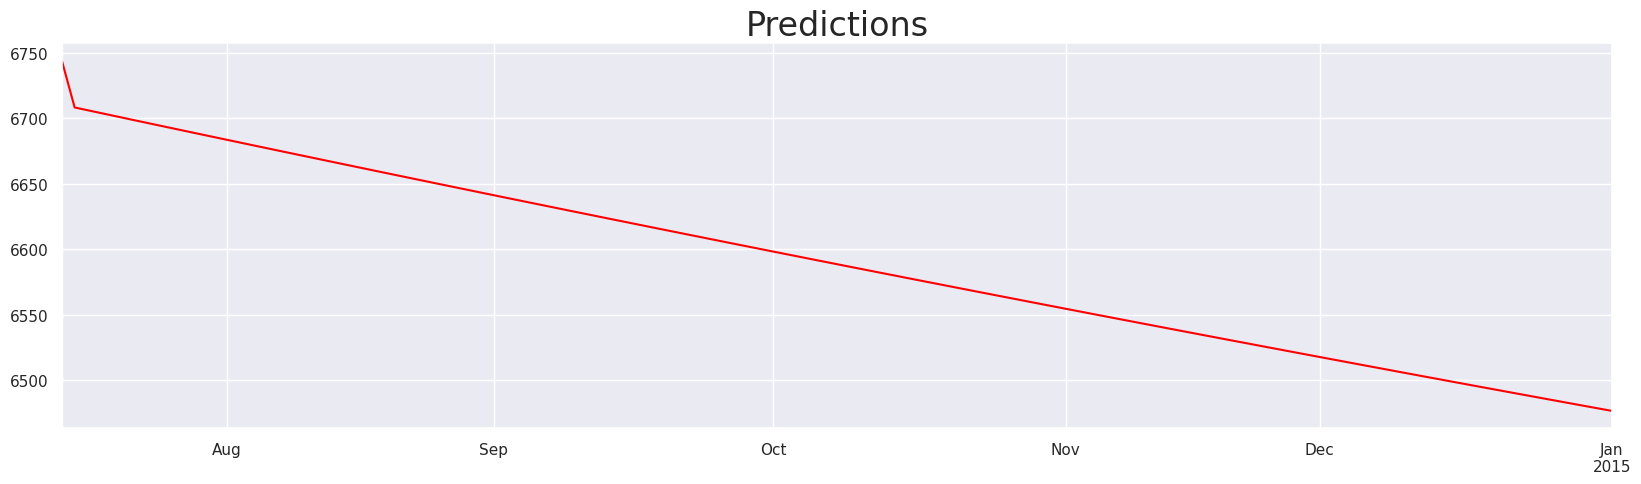

In [12]:
df_pred[start_date:end_date].plot(figsize = (20,5), color= 'red')
plt.title('Predictions', size = 24)
plt.show()

In [13]:
end_date = '2019-10-23'
df_pred = results_ar.predict(start= start_date, end = end_date)

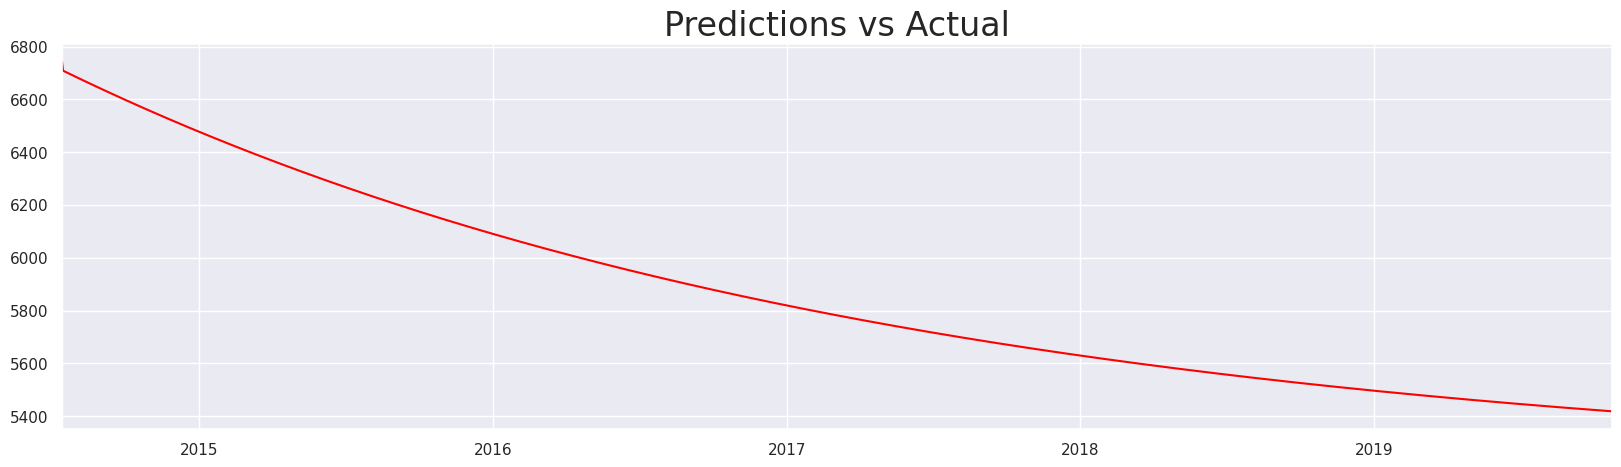

In [14]:
df_pred[start_date:end_date].plot(figsize = (20,5), color= 'red')
plt.title('Predictions vs Actual', size = 24)
plt.show()

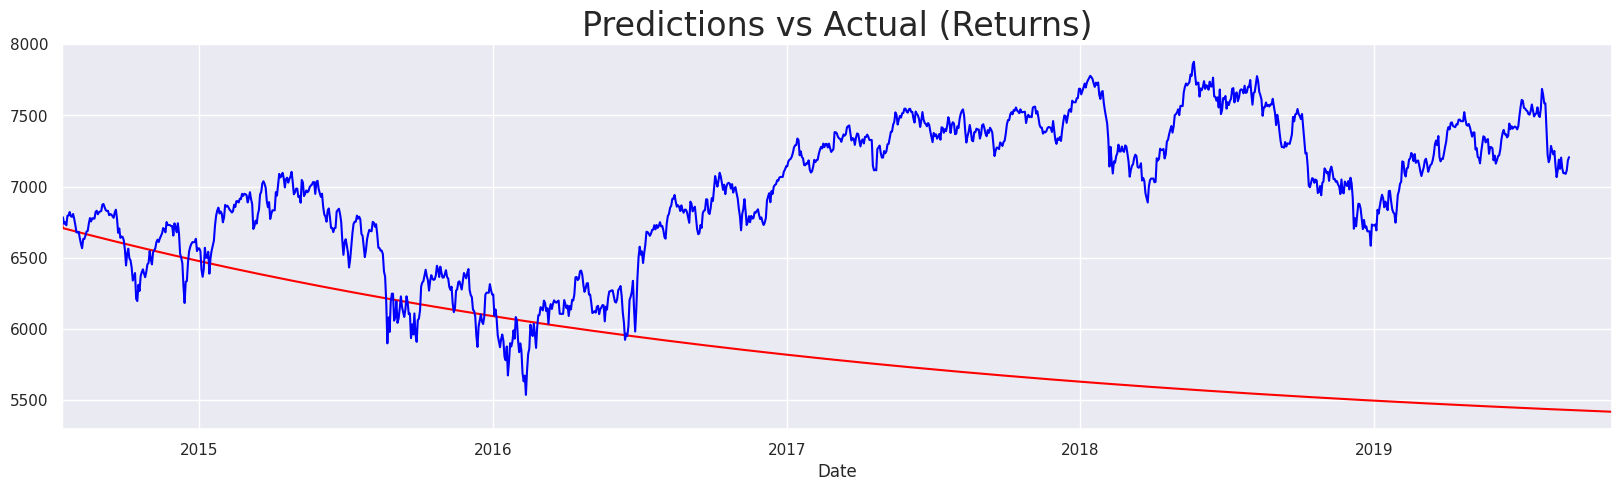

In [15]:
df_pred[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

#Usando Retornos como datos estacionarios para realizar mejores predicciones
##Using Returns Instead

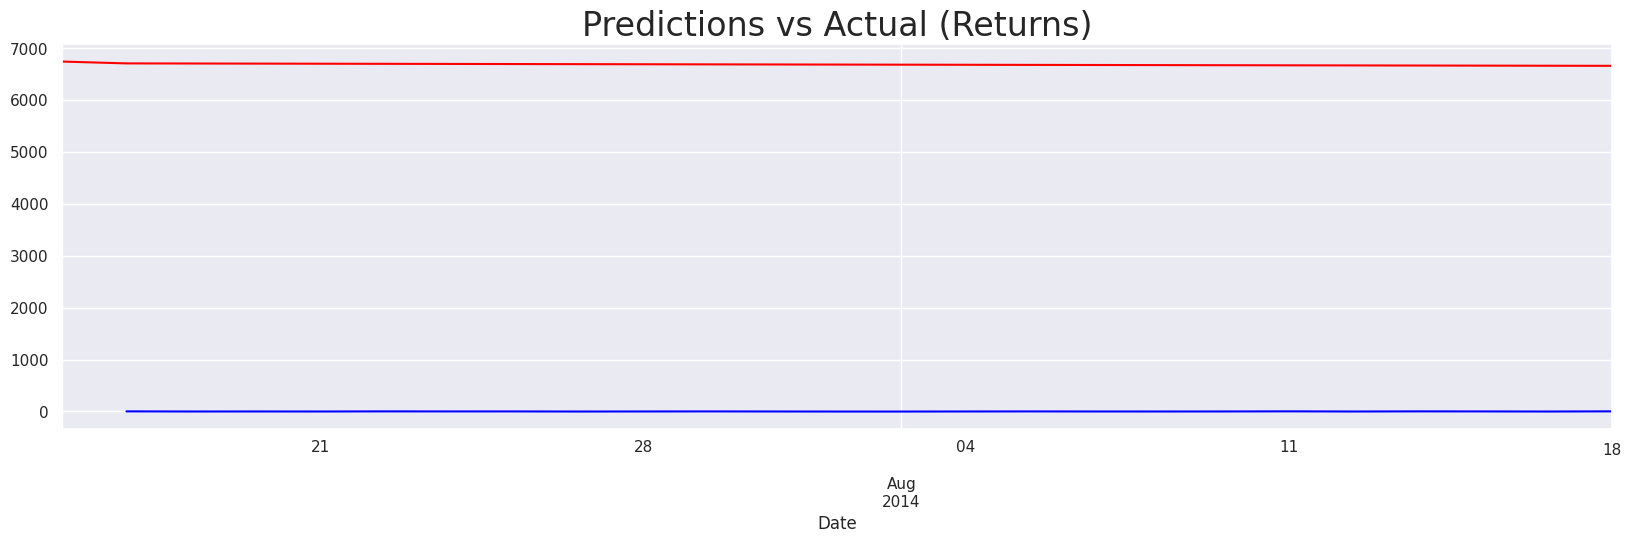

In [16]:
end_date = '2014-08-18'

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

# end_date = '2019-10-23'
# df_pred = results_ar.predict(start= start_date, end = end_date)

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

In [17]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -9651.428
Date:                Tue, 20 Jun 2023   AIC                          19316.855
Time:                        21:46:06   BIC                          19362.951
Sample:                    01-11-1994   HQIC                         19332.956
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0384      0.020      1.968      0.049       0.000       0.077
ar.L1         -0.0122      0.010     -1.266      0.205      -0.031       0.007
ar.L2         -0.0248      0.008     -2.955      0.003      -0.041      -0.008
ar.L3         -0.0359      0.008     -4.268      0.000      -0.052      -0.019
ar.L4          0.0275      0.009      3.086      0.002       0.010       0.045
ar.L5         -0.0390      0.009     -4.563      0.000      -0.056      -0.022
sigma2         2.1586      0.024     91.453      0.000       2.112       2.205
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4667.87
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MA

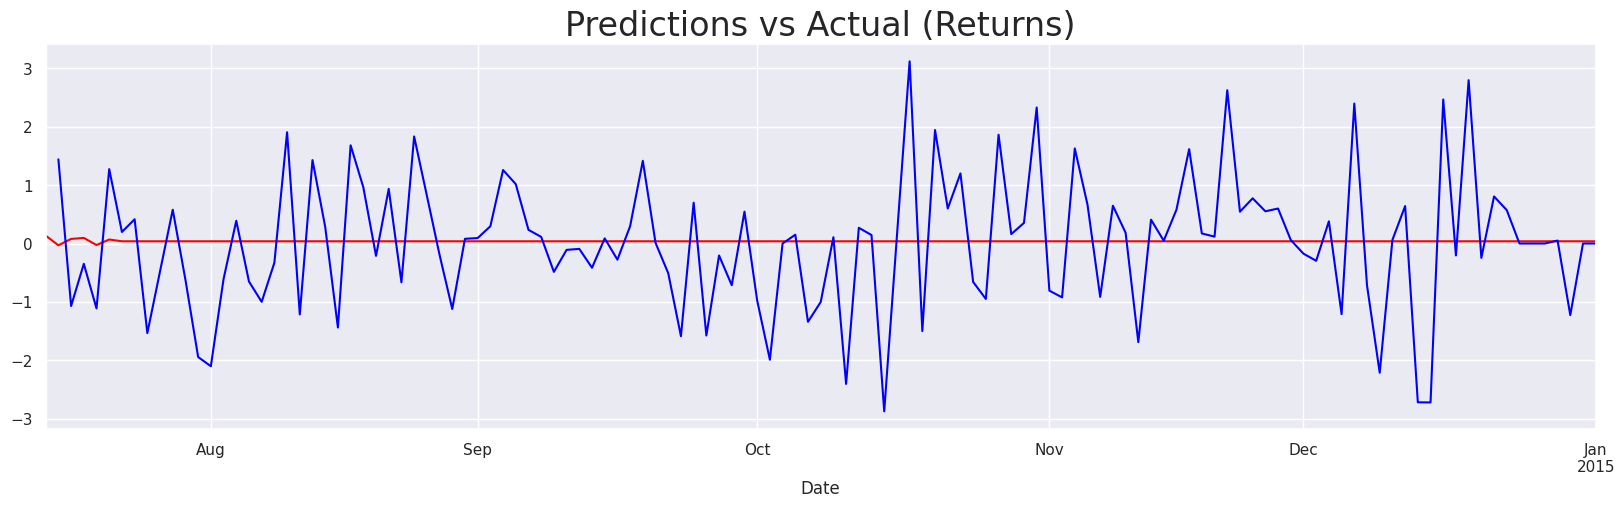

In [18]:
end_date = '2015-01-01'
#1 o 5 retrasos de medias moviles o residuos no hacen diferencia
model_ret_ma = ARIMA(df.ret_ftse[1:], order = (0,0,5))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date)

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

In [19]:
results_ret_ma.summary()
#No son significativos los coeficientes, las predicciones son cercanas a cero

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -9651.581
Date:                Tue, 20 Jun 2023   AIC                          19317.162
Time:                        21:46:11   BIC                          19363.257
Sample:                    01-11-1994   HQIC                         19333.262
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0384      0.019      1.974      0.048       0.000       0.077
ma.L1         -0.0136      0.010     -1.399      0.162      -0.033       0.005
ma.L2         -0.0249      0.008     -2.968      0.003      -0.041      -0.008
ma.L3         -0.0347      0.009     -4.064      0.000      -0.051      -0.018
ma.L4          0.0265      0.009      2.972      0.003       0.009       0.044
ma.L5         -0.0382      0.008     -4.505      0.000      -0.055      -0.022
sigma2         2.1587      0.024     91.575      0.000       2.112       2.205
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4667.78
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
df_pred_ma.head()

2014-07-15    0.135579
2014-07-16   -0.030039
2014-07-17    0.078831
2014-07-18    0.095904
2014-07-21   -0.025675
Freq: B, Name: predicted_mean, dtype: float64

##ARMA
La combinanciones de AR-MA tampoco muestra predicciones fiables, todas muy cercanas a cero

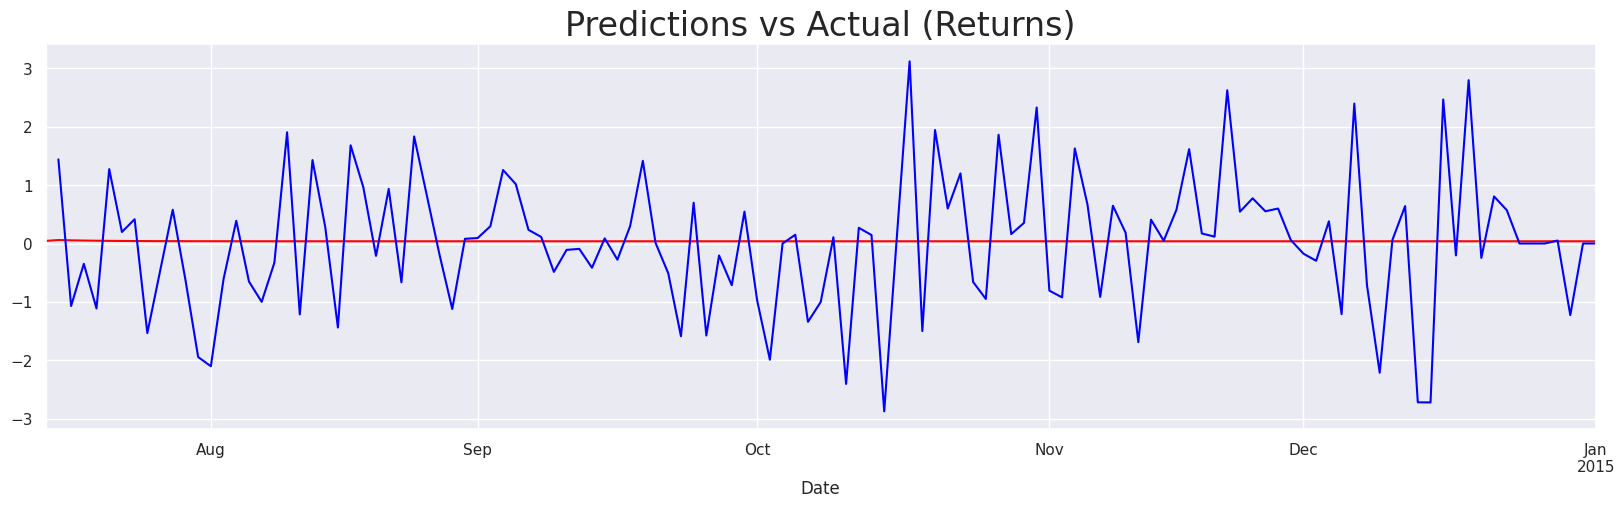

In [21]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_ret_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_ret_arma[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

In [22]:
df_pred_ret_arma.head()

2014-07-15    0.044596
2014-07-16    0.059936
2014-07-17    0.054717
2014-07-18    0.050766
2014-07-21    0.047776
Freq: B, Name: predicted_mean, dtype: float64

In [23]:
df_pred_ret_arma.tail()
#Se estabilizan las predicciones muy cercanas a cero
#Ocurre igual que con MA

2014-12-26    0.038464
2014-12-29    0.038464
2014-12-30    0.038464
2014-12-31    0.038464
2015-01-01    0.038464
Freq: B, Name: predicted_mean, dtype: float64

#MODELOS MAXIMOS

>Modelos integrados solo se usan en datos no estacionarios.



##ARMAX
Las predicciones es encuentran cercanas a las reales a veces subestima o sobreestima algunos retornos.

La inclusión de factores externos de otros precios del mercado mejoran las predicciones.

Desventaja de modelos maximos, aunque puede mejorar en gran medida las predicciones, es que las variables exogenas son medidas del pasado.

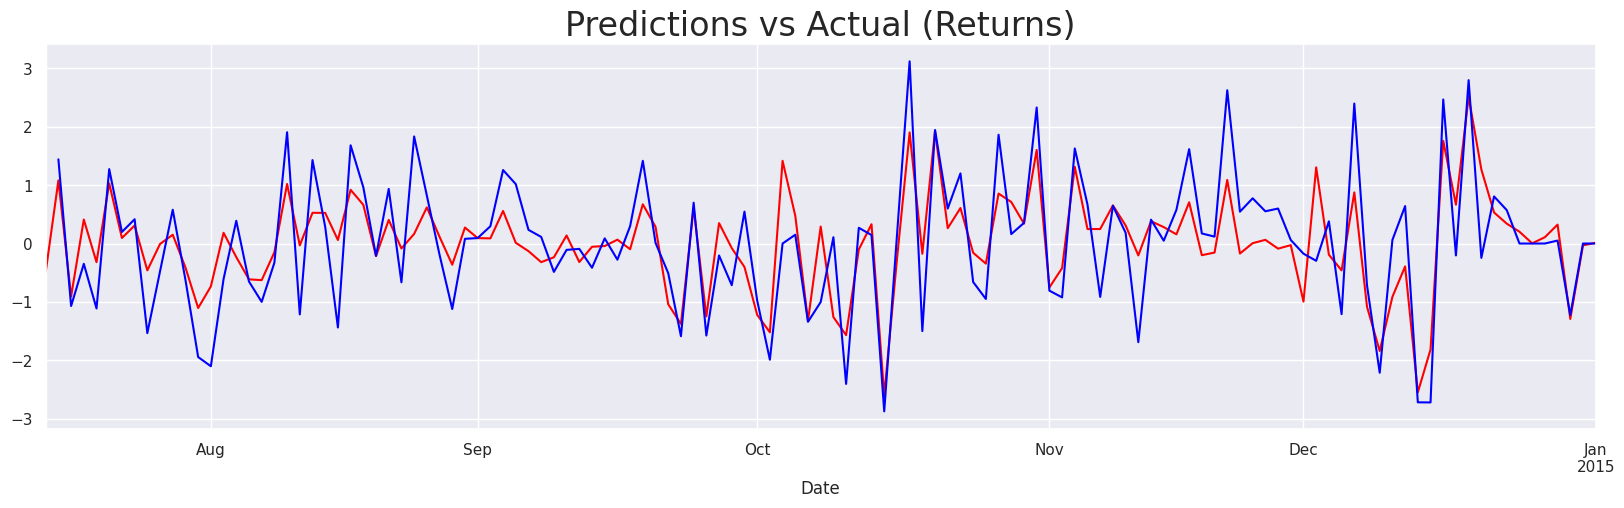

In [24]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog= df[['ret_spx','ret_dax','ret_nikkei']][1:], order= (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_ret_armax = results_ret_armax.predict(start = start_date, end = end_date,
                                              exog= df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])

#le pasamos lo que valen las var exogenas desde su inicio a fin
df_pred_ret_armax[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

#PREDICCIONES CON ESTACIONALIDAD

Los no estacionales solo tienen 3 ordenes, mientras  que los estacionales van a tener 4 ordenes más.
(tres ordernes estacionales, duración de ciclo estacional)

La longitud del ciclo estacional debe ser correcta. En este caso se desea saber que pasa semana tras semana laboral.

##SARMA

La magnitud del cambio es demasiado pequeña en comparación con el movimiento real, es decir los modelos sarma dan estabilidad pero carecen de precisión.

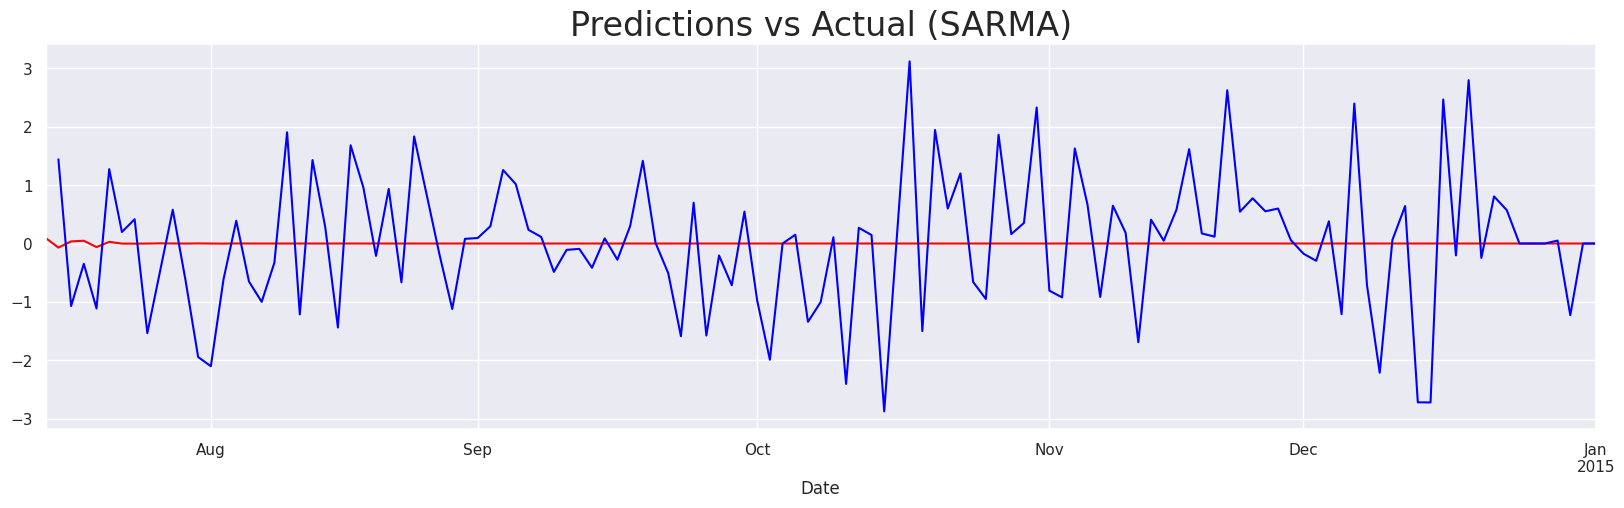

In [25]:
end_date = '2015-01-01'
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order= (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_ret_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_ret_sarma[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (SARMA)', size = 24)
plt.show()

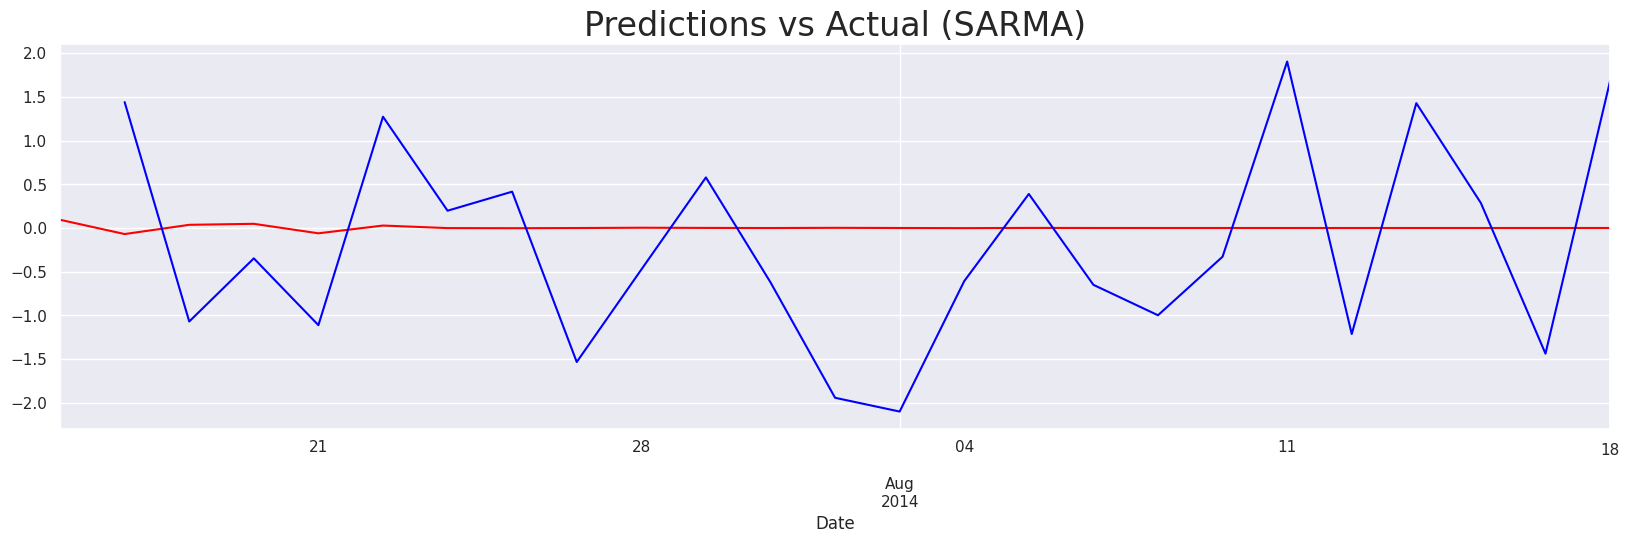

In [26]:
end_date = '2014-08-18'
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order= (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_ret_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_ret_sarma[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (SARMA)', size = 24)
plt.show()

##SARIMAX

#La información exógena mejora las predicciones

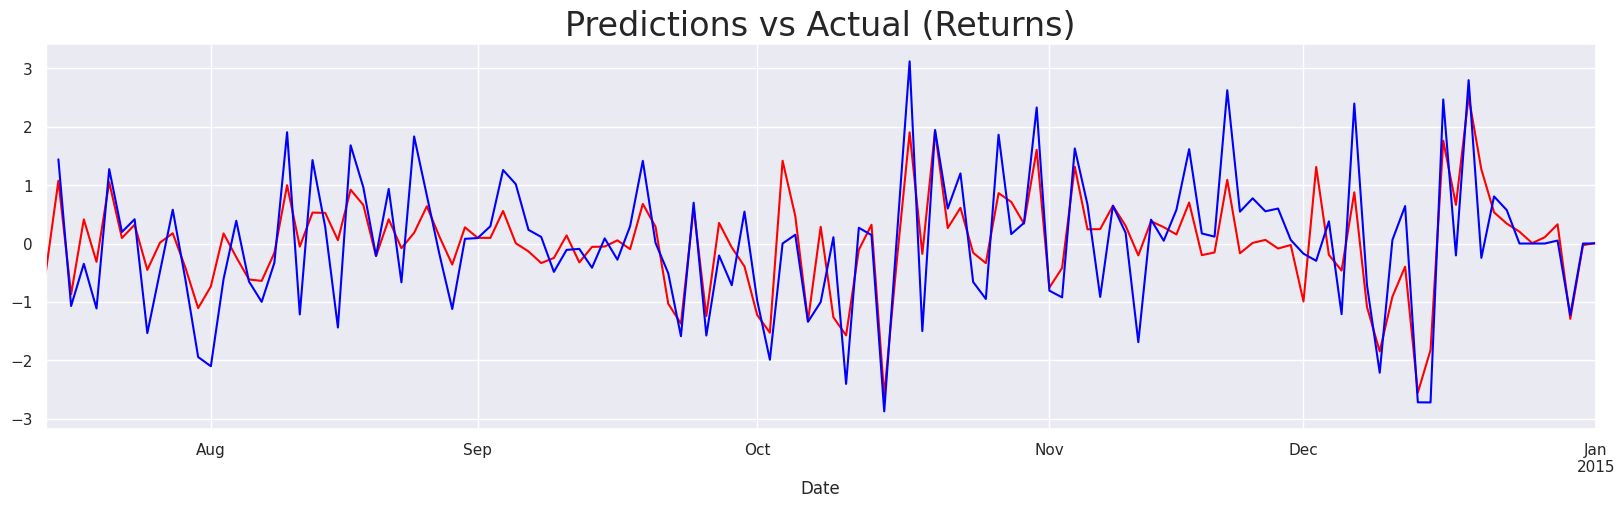

In [27]:
end_date = '2015-01-01'
model_ret_sarimax = ARIMA(df.ret_ftse[1:], exog= df[['ret_spx','ret_dax','ret_nikkei']][1:],
                          order= (3,0,4), seasonal_order= (3,0,2,5))

results_ret_sarimax = model_ret_sarimax.fit()

df_pred_ret_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date,
                                                exog= df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])

#le pasamos lo que valen las var exogenas desde su inicio a fin
df_pred_ret_sarimax[start_date:end_date].plot(figsize = (20,5), color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

##Auto-ARIMA
No crea un dataFrame de las predicciones como los anteriores modelos.

In [28]:
model_auto0= auto_arima(df.ret_ftse[1:])

In [29]:
#data frame para poder dibujarlas predicciones que crea el auto_arima
#donde le pasamos las predicciones basadas en la cantidad que tiene el cojunto de datos de prueba
#como indice le pasamos los indixes que tiene el cojunto de prueba desde la fecha inicial a final
df_auto_pred0 = pd.DataFrame(model_auto0.predict(n_periods = len(df_test[start_date:end_date])), index = df_test[start_date:end_date].index)


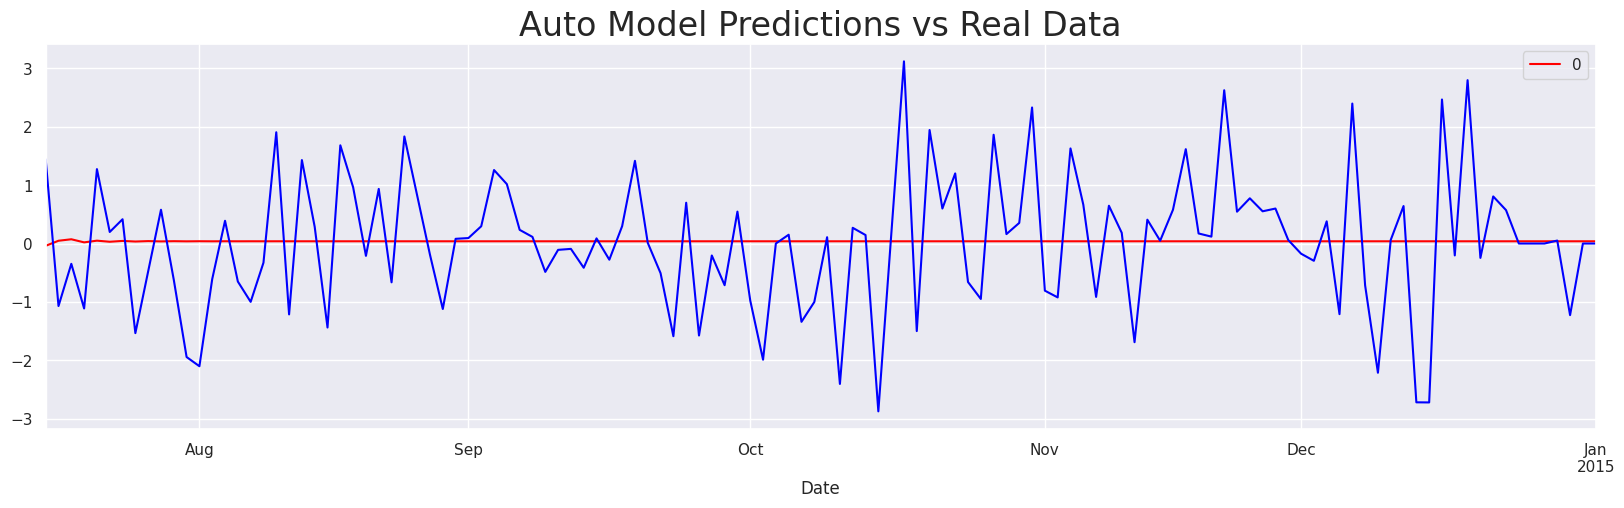

In [30]:
df_auto_pred0.plot(figsize= (20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color ='blue')
plt.title('Auto Model Predictions vs Real Data', size= 24)
plt.show()

Cambiando valores por defecto que viene con el auto_arima

In [31]:
df_test

,spx,dax,ftse,nikkei,ret_spx,ret_dax,ret_ftse,ret_nikkei,norm_ret_spx,norm_ret_dax,norm_ret_ftse,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-16,1981.569946,9859.269531,6784.700195,15379.299805,0.420108,1.105733,1.438970,-0.103022,-175.147139,-184.735468,793.605755,-45.444849
2014-07-17,1958.119995,9753.879883,6738.299805,15370.259766,-1.183403,-0.683897,-1.068940,-0.058781,493.371572,137.230874,-490.846406,-25.929241
2014-07-18,1978.219971,9720.019531,6749.500000,15215.709961,1.026494,0.166217,-0.347148,-1.005512,-427.954713,44.566925,119.297106,-443.550752
2014-07-21,1973.630005,9612.049805,6728.399902,15215.709961,-0.232025,-0.312617,-1.110797,0.000000,96.733401,142.604581,-224.371403,0.000000
2014-07-22,1983.530029,9734.330078,6795.299805,15343.280273,0.501615,0.994291,1.272156,0.838412,-209.127965,-163.319861,713.622161,369.839646
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,2878.379883,11658.040039,7095.000000,20261.039062,1.098299,0.000000,0.400725,-2.172145,-457.890976,-51.445279,0.000000,-958.175298
2019-08-27,2869.159912,11730.019531,7089.600098,20456.080078,-0.320318,-0.076109,0.617424,0.962641,133.543581,-79.265070,-54.624584,424.639414


In [32]:
import pmdarima as pm

In [33]:
model_auto1 = pm.auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax','ret_nikkei']][1:],
                        m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

#m : longitud maxima del ciclo
# max_ valores maximos que toma tanto para la parte AR y MA, tanto para la parte estacional y no estacional

In [34]:
df_auto_pred = pd.DataFrame(model_auto1.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
                            ,index = df_test[start_date:end_date].index)

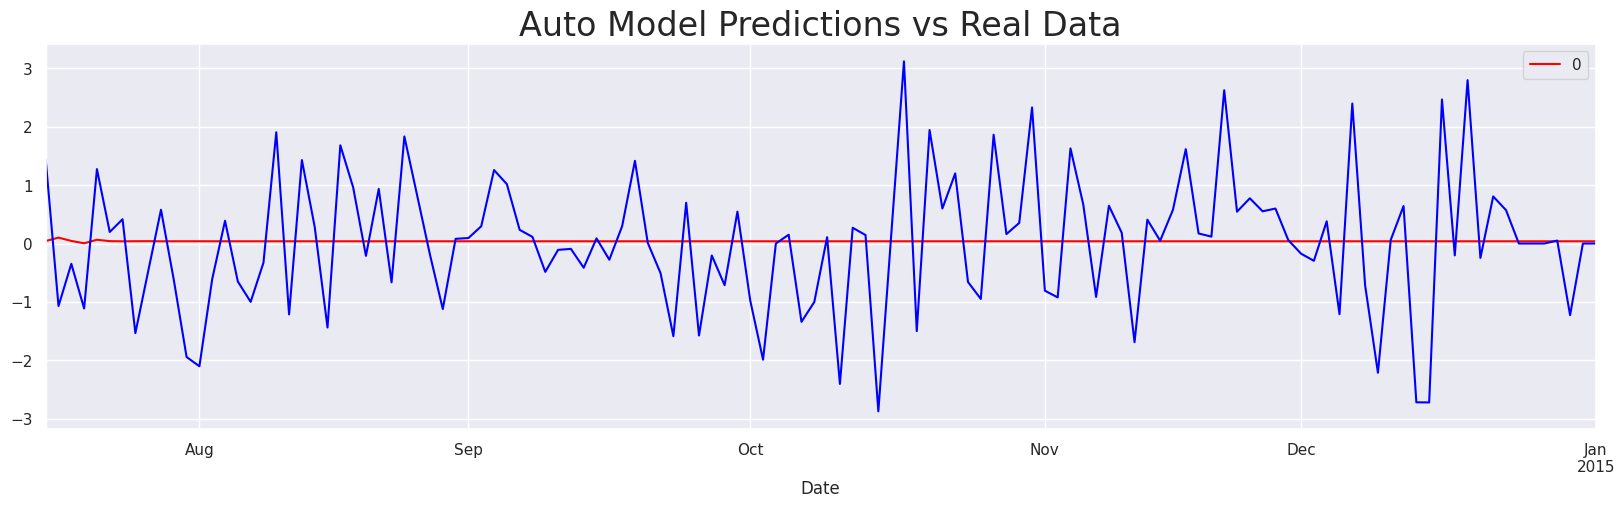

In [35]:
df_auto_pred.plot(figsize= (20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color= 'blue')
plt.title('Auto Model Predictions vs Real Data', size= 24)
plt.show()

##Comparing ALL the Models (Returns)

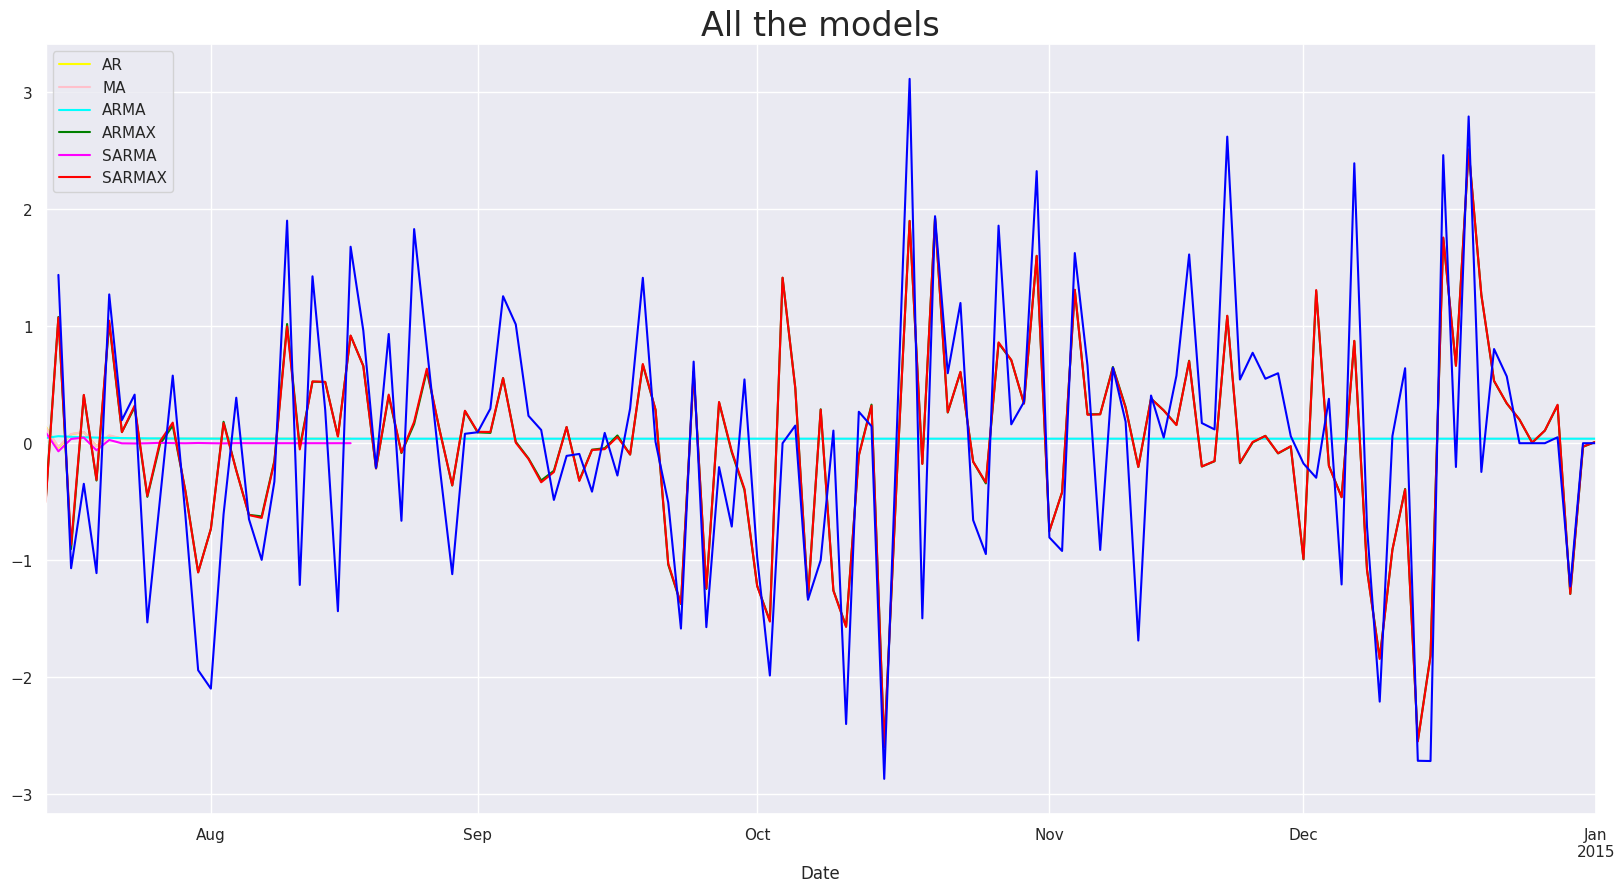

In [36]:
end_date = '2015-01-01'
df_pred_ar[start_date:end_date].plot(figsize= (20,10), color= 'yellow')
df_pred_ma[start_date:end_date].plot(color= 'pink')
df_pred_ret_arma[start_date:end_date].plot(color= 'cyan')
df_pred_ret_armax[start_date:end_date].plot(color= 'green')
df_pred_ret_sarma[start_date:end_date].plot(color= 'magenta')
df_pred_ret_sarimax[start_date:end_date].plot(color= 'red')
df_test.ret_ftse[start_date:end_date].plot(color= 'blue')
plt.legend(['AR', 'MA', 'ARMA', 'ARMAX', 'SARMA', 'SARMAX']) #NO HUBO INTEGRACIÓN
plt.title('All the models', size=24)
plt.show()

##como no sabemos cuales son las variables exogenas en el futuro esto hace que sea imposible predecir la variable endogena de retornro


##Forecasting Volatility

In [39]:
start_date
end_date

'2015-01-01'

In [37]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = 'GARCH', p=1, q=1, mean='constant', dist='Normal')
res_garch = mod_garch.fit(last_obs = start_date, update_freq= 10) #para que no se muestren todas las iteraciones
#last_obs = start_date ultimo argumento sea igual a la fecha de inicio de predicciones

Iteration:     10,   Func. Count:     65,   Neg. LLF: 8681.895052975502
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8681.895052975502
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


In [43]:
#Pronostico: 1. horizon cuantas observaciones queremos que prediga el modelo para cad fecha
#2. aling: si queremos hacer coincidir el valor con la fecha para la que se hace la predicción o con la que se supone que representa
pred_garch = res_garch.forecast(horizon = 1 , align= 'target')


#target es la ultima opción, la primera es origin

Predicciones de volatilidad con GARH simple, estas predicciones no son lineales como la de los modelos arma sino que fluctuan en función de la varianza condicional pasada.

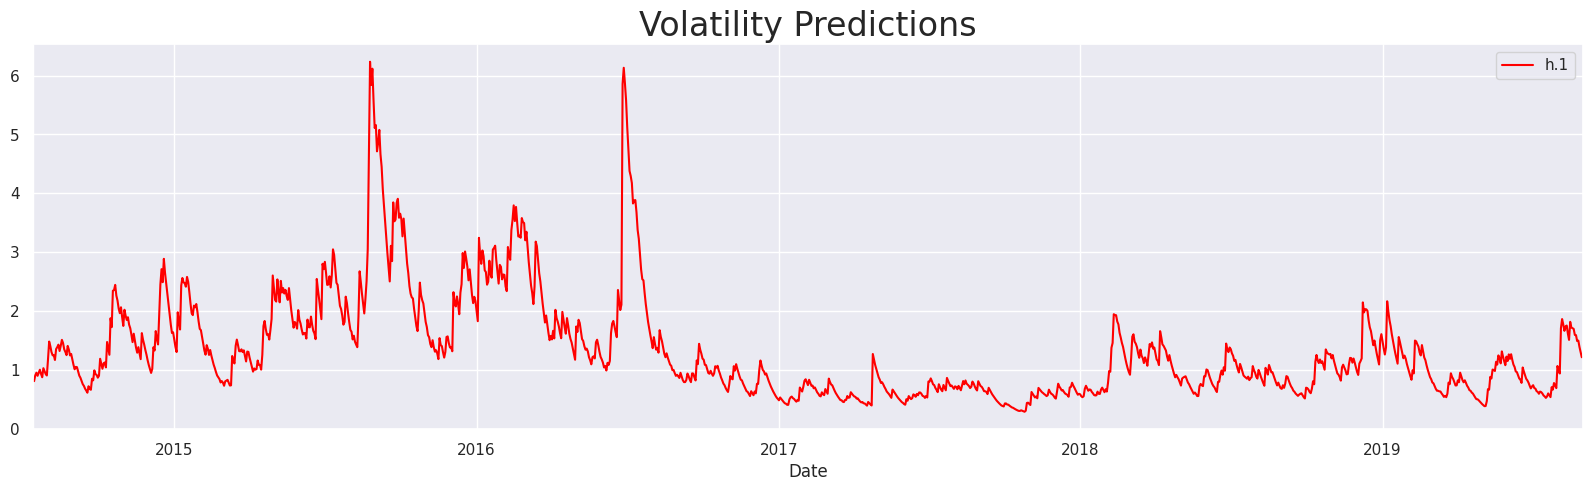

In [44]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color= 'red', zorder = 2)
plt.title('Volatility Predictions', size = 24)
plt.show()

Proporciona buenos valores

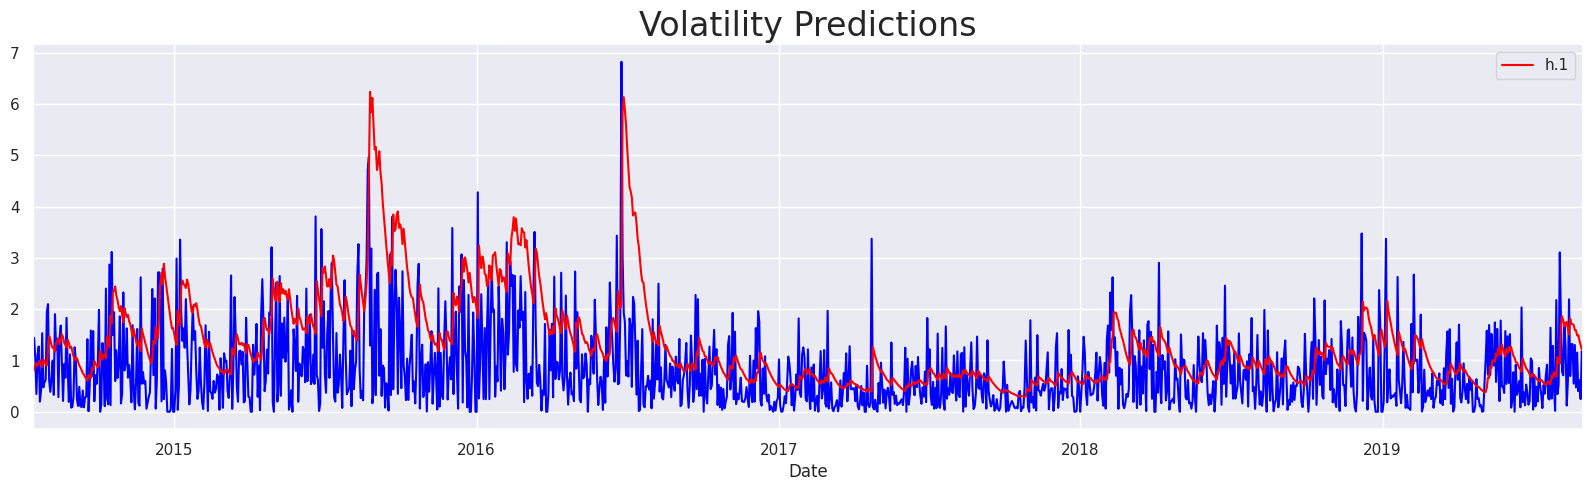

In [45]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color= 'red', zorder = 2)
df_test.ret_ftse.abs().plot(color= 'blue', zorder = 1)  #abs= obtar por valores positivos porque volatilidad es positiva
plt.title('Volatility Predictions', size = 24)
plt.show()

#zorder= 2 para tener un grafico sobre el otro  varianza residual
#zorder = 1, retornos de ftse porque hay un desplazamiento de 1 dia sobre las dos

##Pronosticar el futuro
Argumento horizonte proporciona cuantos valores queremos para predecir hacia adelante  para cada fecha.

100 días de fututo despues del ultimo dia del conjunto de prueba

#Lo que se pronostica aca es la volatilidad en lugar de los retornos y no podemos transformar la volatilidad para obtener estimaciones de precios, entonces esta es una de las formas en que podemos solucionar el problema de la falta de variables exogenas y la otra solución implica pronosticar los valores de cada una de las variables exogenas.

In [47]:
pred_garch= res_garch.forecast(horizon = 100, align='target')

#como solo nos interesa las 100 prediciones hechas despues del ultima día real, se configura la varianza de los residuos en -1
pred_garch.residual_variance[-1:] #-1 coge apartir del ultimo día del conjunto de datos

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,1.21975,1.220565,1.318056,1.406988,1.518701,1.515635,1.616381,1.624416,1.724732,1.737866,...,1.396113,1.410316,1.417323,1.436231,1.455873,1.476556,1.48956,1.507583,1.517926,1.541305


##Multivariate Regression Model
Tenemos varias regresiones apiladas para cada serie de tiempo que incluimos, y el modelo incluye cada una de ellas en la regresión para estimar valores.

Supongamos que queremos usar un AR de orden 2, la regresion multivariante trataria de ajustar un modelo usando los dos ultimos valores de cada serie de tiempo. 4 regresiones del mismo modelo usando diferentes valores variables endogenas.

Se le conoce como modelo vectoriales: VAR modelo vectorial autoregresivo.
Si incluimos residuos pasados trataremos con un VARMA hay para cada uno VARIMAX

In [48]:
from statsmodels.tsa.api import VAR

In [49]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [50]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)# 20 orden maximo del modelo ya que usamos 4 series
results_var_ret = model_var_ret.fit(ic= 'aic')

In [51]:
results_var_ret.summary()

#Muestra: Valores de coeficientes asociados a los retornos 5 retrasos

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Jun, 2023
Time:                     22:28:23
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.328077
Nobs:                     5346.00    HQIC:                  0.260760
Log likelihood:          -30859.0    FPE:                    1.25185
AIC:                     0.224624    Det(Omega_mle):         1.23237
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039221         0.016160            2.427           0.015
L1.ret_spx           -0.110815         0.017560           -6.310           0.000
L1.ret_dax           -0.012914         0.024447           

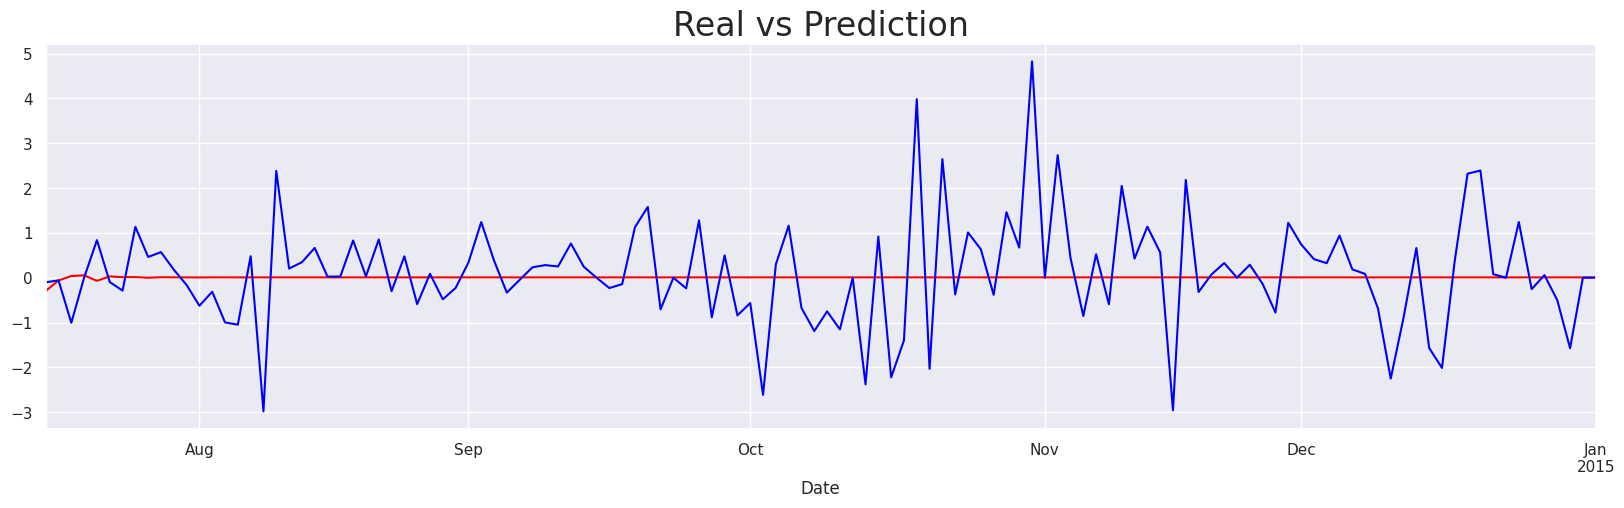

In [53]:
lag_order_ret = results_var_ret.k_ar #contiene el orden de retraso del modelo //.k_ar atributo de la variable de resultados
#lo necesitamos para extraer los valores necesarios para hacer la primera prediccion

#para hacer  pronosticos(valores y duración de intervalo de prediccion )
#df_ret.values[-lag_order_ret:] parte de ahi la predicción
#len(df_test[start_date:end_date] longitud de tiempo de nuestro intervalo de predicciones
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))



##Guardar como en auto_arima //.columns[4:8] tomamos apartir de esta columna que son los retornos
df_ret_pred = pd.DataFrame(data= var_pred_ret, index=df_test[start_date:end_date].index,
                           columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize =(20,5), color= 'red')

df_test.ret_nikkei[start_date:end_date].plot(color= 'blue')
plt.title('Real vs Prediction', size= 24)
plt.show()

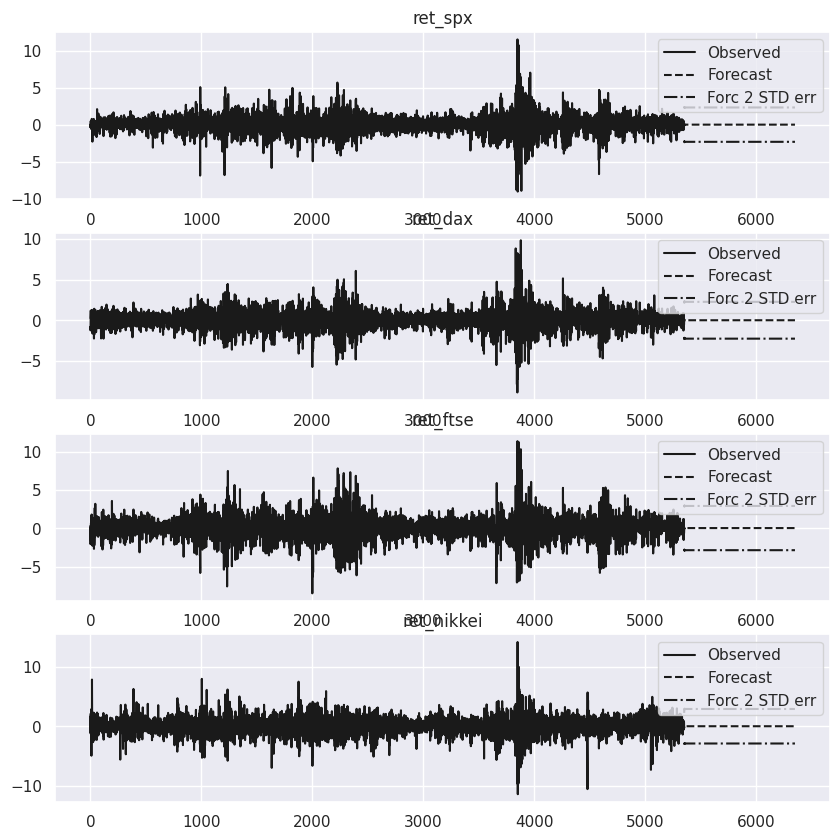

In [54]:
results_var_ret.plot_forecast(1000) #1000  pronosticos
plt.show()